# Import Dependencies

In [124]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import albumentations as A

from tensorflow.keras.layers import Resizing, Rescaling, Layer, RandomRotation, RandomFlip, RandomContrast

# Wandb Install, Login, Initialization and Configuration

In [2]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [39]:
import wandb
from wandb.keras import WandbCallback

In [4]:
!wandb login

wandb: Currently logged in as: timothy-tandt. Use `wandb login --relogin` to force relogin


In [4]:
wandb.init(project="Malaria-Detection", entity='timothy-tandt')

wandb: Currently logged in as: timothy-tandt. Use `wandb login --relogin` to force relogin


In [194]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE":2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}

CONFIGURATION = wandb.config

# Data Preparation

## Data Loading

In [195]:
dataset, dataset_info = tfds.load(
    "malaria", 
    with_info=True,
    as_supervised=True, 
    shuffle_files=True, 
    split=["train"])

In [196]:
for data in dataset[0].take(1):
    print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [197]:
def splits(dataset, train_ratio, val_ratio, test_ratio):
    dataset_size = len(dataset)
    
    train_dataset = dataset.take(int(train_ratio * dataset_size))
    
    val_test_dataset = dataset.skip(int(train_ratio * dataset_size))
    val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))
    
    test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))
    
    return train_dataset, val_dataset, test_dataset

In [198]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [226]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [200]:
print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data Visualization

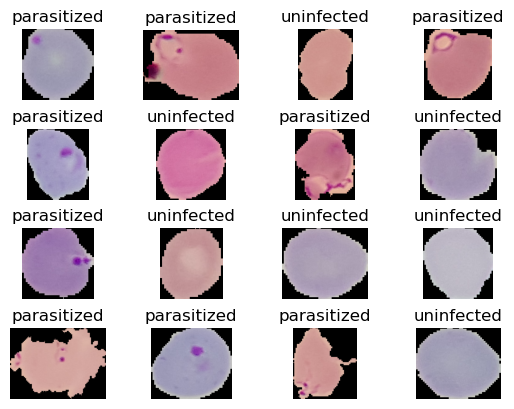

In [201]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis('off')

# Adjusting subplot parameters to add space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust these values as needed
plt.show()

# Data Preprocessing

## Data Augmentation

In [202]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

In [203]:
original_image, label = next(iter(train_dataset))

In [204]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor=0.3)

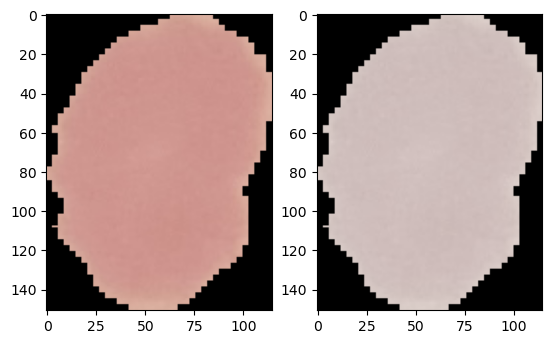

In [205]:
visualize(original_image, augmented_image)

In [206]:
IM_SIZE = 224

In [207]:
original_image, label = next(iter(train_dataset))

@tf.function
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [208]:
_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [209]:
### tf.keras.layer resizing and rescaling

resize_rescale_layers = tf.keras.Sequential()
resize_rescale_layers.add(Resizing(IM_SIZE, IM_SIZE))
resize_rescale_layers.add(Rescaling(1./255))

In [210]:
### tf.image augment

@tf.function
def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)

In [211]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()
    
    @tf.function
    def call(self, image):
        return tf.image.rot90(image)

In [212]:
### tf.keras.layer augment

augment_layers = tf.keras.Sequential()
augment_layers.add(RandomRotation(factor=(0.25, 0.2501)))
augment_layers.add(RandomFlip(mode="horizontal"))
augment_layers.add(RandomContrast(factor=0.1))

@tf.function
def augment_layer(image, label):
    image = resize_rescale_layers(image)
    return augment_layers(image, training=True), label

## Data Loading

In [213]:
BATCH_SIZE = 32

In [214]:
test_dataset, test_dataset.map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)

(<SkipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [215]:
train_dataset = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset = train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [216]:
val_dataset = val_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
val_dataset = val_dataset.map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [217]:
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [218]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Mixup Data Augmentation

In [227]:
train_dataset_1 = train_dataset.shuffle(buffer_size=32).map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size=32).map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [228]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    
    image = lamda * image_1 + (1 - lamda) * image_2
    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1 - lamda) * tf.cast(label_2, dtype=tf.float32)
    
    return image, label

In [230]:
BATCH_SIZE = 32

train_dataset_mixed = mixed_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_mixed = train_dataset_mixed.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_mixed = train_dataset_mixed.batch(BATCH_SIZE)
train_dataset_mixed = train_dataset_mixed.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

tf.Tensor(
[1.0000000e+00 3.2091141e-04 3.2771647e-01 1.0000000e+00 0.0000000e+00
 8.9021575e-01 0.0000000e+00 1.0000000e+00 7.0521593e-02 0.0000000e+00
 1.9875467e-02 9.7124004e-01 1.0000000e+00 9.7960496e-01 0.0000000e+00
 1.0033846e-03 1.0000000e+00 1.0000000e+00 1.0000000e+00 3.4277099e-01
 1.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 1.0000000e+00 5.6890726e-02 1.2680477e-01
 1.0000000e+00 6.3603193e-01], shape=(32,), dtype=float32)


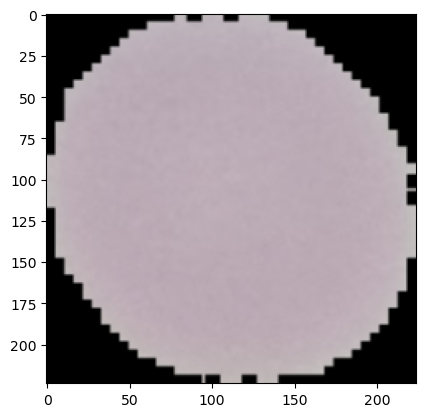

In [231]:
original_image, label = next(iter(train_dataset_mixed))
print(label)
plt.imshow(original_image[0])

## Cutmix Data Augmentation

In [69]:
def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

    r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
    r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
    r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

    r_w = x_b_r - r_x
    if(r_w == 0):
        r_w  = 1

    r_h = y_b_r - r_y
    if(r_h == 0):
        r_h = 1

    return r_y, r_x, r_h, r_w

In [84]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]
    
    r_y, r_x, r_h, r_w = box(lamda)
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

    image = image_1 - pad_1 + pad_2
    lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
    label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

    return image, label

In [72]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>

## Albumentations

In [95]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/albu/albumentations to c:\users\timothy tandt\appdata\local\temp\pip-req-build-dyne6brt
  Resolved https://github.com/albu/albumentations to commit 4e478679e67aa40df5912de5047ee7748be68774
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.6 MB 991.0 kB/s eta 0:00:11
    --------------------------------------- 0.2/1

  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations 'C:\Users\Timothy Tandt\AppData\Local\Temp\pip-req-build-dyne6brt'


In [240]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    
    A.OneOf([A.HorizontalFlip(),
            A.VerticalFlip()], p=0.3),
    
    A.RandomRotate90(),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                              contrast_limit=0.2,
                              always_apply=False, p=0.5),
])

In [241]:
def aug_albument(image):
    data = { "image": image }
    
    image = transforms(**data)
    image = image["image"]
    image = tf.cast(image/255., tf.float32)
    
    return image

In [242]:
def process_data(image, label):
    aug_image = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    
    return aug_image, label

In [245]:
train_dataset_transformed = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)
train_dataset_transformed = train_dataset_transformed.map(process_data)
train_dataset_transformed = train_dataset_transformed.batch(BATCH_SIZE)
train_dataset_transformed = train_dataset_transformed.prefetch(tf.data.AUTOTUNE)

In [246]:
train_dataset_transformed

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [247]:
im, _ = next(iter(train_dataset_transformed))


UnknownError: AttributeError: module 'albumentations.augmentations.functional' has no attribute 'resize'
Traceback (most recent call last):

  File "C:\ProgramData\anaconda3\envs\py310\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "C:\ProgramData\anaconda3\envs\py310\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Timothy Tandt\AppData\Local\Temp\ipykernel_21120\765704725.py", line 4, in aug_albument
    image = transforms(**data)

  File "C:\Users\Timothy Tandt\AppData\Roaming\Python\Python310\site-packages\albumentations\core\composition.py", line 213, in __call__
    data = t(**data)

  File "C:\Users\Timothy Tandt\AppData\Roaming\Python\Python310\site-packages\albumentations\core\transforms_interface.py", line 119, in __call__
    return self.apply_with_params(params, **kwargs)

  File "C:\Users\Timothy Tandt\AppData\Roaming\Python\Python310\site-packages\albumentations\core\transforms_interface.py", line 132, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))

  File "C:\Users\Timothy Tandt\AppData\Roaming\Python\Python310\site-packages\albumentations\augmentations\transforms.py", line 469, in apply
    Targets:

AttributeError: module 'albumentations.augmentations.functional' has no attribute 'resize'


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]